In [41]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import keras
from keras import layers
import keras_tuner


In [42]:
def read_data(type, folder, length):
    df = pd.DataFrame()
    parameters = pd.read_csv('Simulation_'+type+'/parameters_v1.txt')
    for i in range(length):
        new_data = pd.read_csv('Simulation_'+type+'/'+folder+'/'+type+'_X_data.csv/'+type+'_'+str(i+1)+'_data.csv')
        mean_force = new_data['FKN'].mean()
        max_force = new_data['FKN'].max()
        new_data_df = pd.DataFrame()
        new_data_df['mean_force'] = [mean_force]
        new_data_df['max_force'] = [max_force]
        for parameter in parameters.columns:
            new_data_df[parameter] = parameters[parameter][i]
        df = pd.concat([df, new_data_df])
    df = df.drop(columns=['sample'])
    df.reset_index(drop=True, inplace=True)

    return df

df = read_data(type='BENDING', folder='CONSTANT_THICKNESS_100', length=100)

In [43]:
X = df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
Y = df[['max_force']].values

In [44]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_train = Y_train.ravel()
Y_val = Y_val.ravel()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [45]:
C_values = np.linspace(1, 100, num=100)
epsilon_values = np.logspace(-2, 1, num=100)
gamma_values = np.logspace(-2, 2, num=100)
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

In [46]:
values = []
for i in range(1000):
    C = np.random.choice(C_values)
    epsilon = np.random.choice(epsilon_values)
    gamma = np.random.choice(gamma_values)

    svr = SVR(kernel='rbf', C=19, epsilon=epsilon, gamma=gamma)
    svr.fit(X_train, Y_train)
    Y_pred = svr.predict(X_val)
    mse = mean_squared_error(Y_val, Y_pred)
    values.append([mse, epsilon, C, gamma])

In [47]:
values = np.array(values)
print(values[:,0].argmin())
print(values[values[:,1].argmax()])
# Create a csv file of values
data = pd.DataFrame(values, columns=['mse', 'epsilon', 'C', 'gamma'])
#data = data.sort_values(by='C')


296
[3.40146746e+00 1.00000000e+01 6.30000000e+01 5.33669923e-02]


In [48]:
"""# Fit a polynomial of degree 2 (quadratic) or another degree based on the trend you observe
coefficients = np.polyfit(data['C'], np.log10(data['mse']), deg=100)  # Adjust 'deg' as needed
polynomial = np.poly1d(coefficients)

# Create a range of x-values for plotting the fitted line
x_values = np.linspace(data['C'].min(), data['C'].max(), 100)
y_values = 10**polynomial(x_values)  # Convert back from log10 if your y-axis is log-scale

# Calculate the minimum MSE and find corresponding C value
min_mse_index = data['mse'].idxmin()
min_c = data['C'][min_mse_index]
min_mse = data['mse'][min_mse_index]

# Existing plot code
plt.figure(figsize=(10, 6))
plt.plot(data['C'], data['mse'], lw=4)  # Existing line plot

# Highlight the minimum value with a red dot
plt.plot(min_c, min_mse, 'ro', markersize=12)  # s is the size of the dot
plt.annotate(f'({min_c:.0f}, {min_mse:.2f})', xy=(min_c, min_mse), xytext=(min_c-5, min_mse+0.004), fontsize=18)

# Set labels and title
plt.xlabel('C', fontsize=18)
plt.ylabel('MSE', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('log')
plt.grid(True)
plt.show()"""

"# Fit a polynomial of degree 2 (quadratic) or another degree based on the trend you observe\ncoefficients = np.polyfit(data['C'], np.log10(data['mse']), deg=100)  # Adjust 'deg' as needed\npolynomial = np.poly1d(coefficients)\n\n# Create a range of x-values for plotting the fitted line\nx_values = np.linspace(data['C'].min(), data['C'].max(), 100)\ny_values = 10**polynomial(x_values)  # Convert back from log10 if your y-axis is log-scale\n\n# Calculate the minimum MSE and find corresponding C value\nmin_mse_index = data['mse'].idxmin()\nmin_c = data['C'][min_mse_index]\nmin_mse = data['mse'][min_mse_index]\n\n# Existing plot code\nplt.figure(figsize=(10, 6))\nplt.plot(data['C'], data['mse'], lw=4)  # Existing line plot\n\n# Highlight the minimum value with a red dot\nplt.plot(min_c, min_mse, 'ro', markersize=12)  # s is the size of the dot\nplt.annotate(f'({min_c:.0f}, {min_mse:.2f})', xy=(min_c, min_mse), xytext=(min_c-5, min_mse+0.004), fontsize=18)\n\n# Set labels and title\nplt.xl

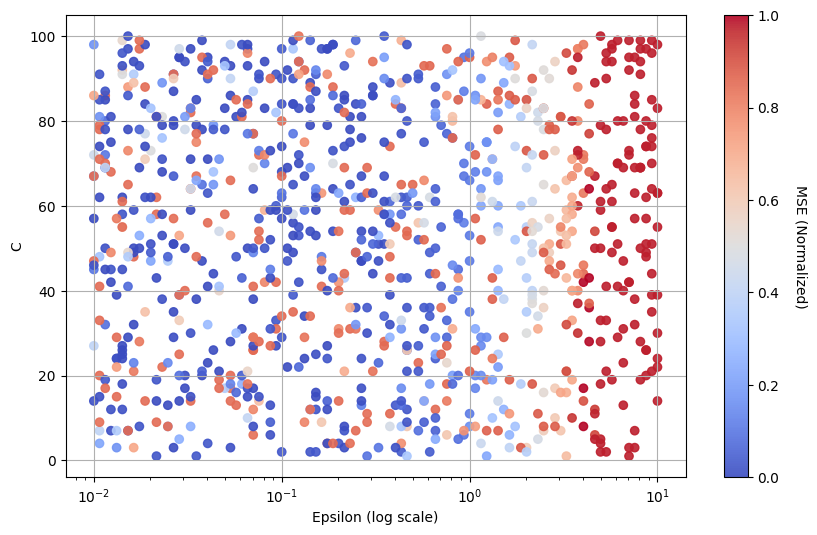

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Normalize the 'mse' column for color mapping
mse_normalized = (data['mse'] - data['mse'].min()) / (data['mse'].max() - data['mse'].min())

# Create a colormap object
cmap = plt.cm.coolwarm  # Use any other colormap if you prefer

# Create a color map from blue to red using the colormap object
colors = cmap(mse_normalized)

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['epsilon'], data['C'], c=mse_normalized, cmap=cmap, alpha=0.9)
plt.xscale('log')  # Set the x-axis to a logarithmic scale
colorbar = plt.colorbar(scatter, label='MSE (Normalized)')  # Add a color bar to the plot to indicate color scale
colorbar.set_label('MSE (Normalized)', rotation=270, labelpad=20)
plt.xlabel('Epsilon (log scale)')  # Label for x-axis
plt.ylabel('C')  # Label for y-axis
plt.grid(True)  # Show grid lines
plt.show()  # Display the plot


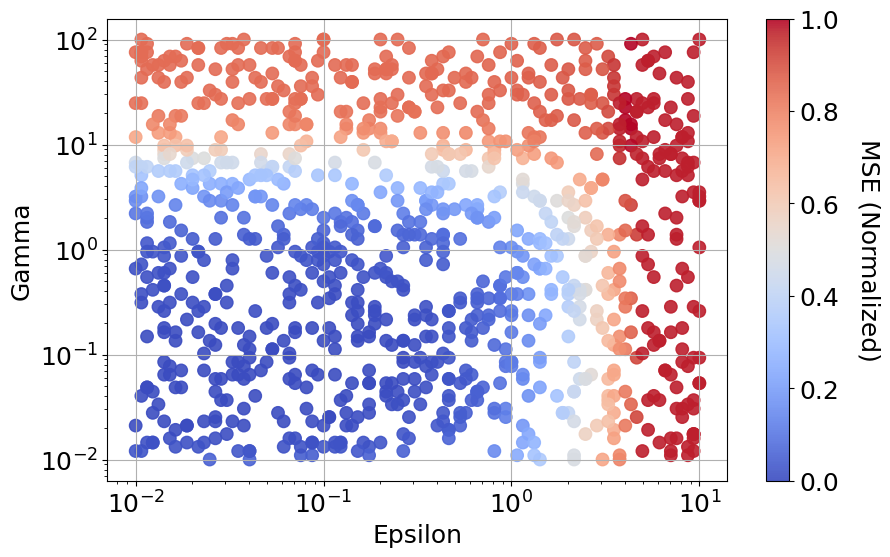

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Normalize the 'mse' column for color mapping
mse_normalized = (data['mse'] - data['mse'].min()) / (data['mse'].max() - data['mse'].min())

# Create a colormap object
cmap = plt.cm.coolwarm  # Use any other colormap if you prefer

# Create a color map from blue to red using the colormap object
colors = cmap(mse_normalized)

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['epsilon'], data['gamma'], c=mse_normalized, cmap=cmap, alpha=0.9, s=80)
plt.xscale('log')  # Set the x-axis to a logarithmic scale
plt.yscale('log')  # Set the x-axis to a logarithmic scale
colorbar = plt.colorbar(scatter, label='MSE (Normalized)')  # Add a color bar to the plot to indicate color scale
colorbar.set_label('MSE (Normalized)', rotation=270, labelpad=30, fontsize=18)  # Adjust fontsize as needed
for label in colorbar.ax.get_yticklabels():
    label.set_size(18)
plt.xlabel('Epsilon', fontsize=18)  # Label for x-axis
plt.ylabel('Gamma', fontsize=18)  # Label for y-axis
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)  # Show grid lines
plt.show()  # Display the plot

In [51]:
"""space = dict()
space['C'] = np.linspace(1, 100, num=100)
space['epsilon'] = np.logspace(-3, 1, num=100)"""

"space = dict()\nspace['C'] = np.linspace(1, 100, num=100)\nspace['epsilon'] = np.logspace(-3, 1, num=100)"

In [52]:
"""search = RandomizedSearchCV(
    estimator=SVR(kernel='rbf'), 
    param_distributions=space, 
    n_iter=1000, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1,
    random_state=42
)"""

"search = RandomizedSearchCV(\n    estimator=SVR(kernel='rbf'), \n    param_distributions=space, \n    n_iter=1000, \n    scoring='neg_mean_squared_error', \n    n_jobs=-1,\n    random_state=42\n)"

In [53]:
"""result = search.fit(X_train, Y_train)"""

'result = search.fit(X_train, Y_train)'

In [54]:
"""print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)"""

"print('Best Score: %s' % result.best_score_)\nprint('Best Hyperparameters: %s' % result.best_params_)"

In [55]:
SVR_model = SVR(kernel='rbf', C=19, gamma=0.1, epsilon=0.1)
#SVR_model = SVR(kernel='rbf', epsilon=0.01, C=50)
SVR_model.fit(X_train,Y_train)

SVR(C=19, gamma=0.1)

In [56]:
Y_predicted_SVR = SVR_model.predict(X_val)

In [57]:
mse_SVR = mean_squared_error(Y_val, Y_predicted_SVR)
print("MSE, for SVR:", mse_SVR)


MSE, for SVR: 0.01266462625652412


In [58]:
mae_SVR = mean_absolute_error(Y_val, Y_predicted_SVR)
print("MAE, for SVR:", mae_SVR)

MAE, for SVR: 0.09111931792082614


In [59]:
mape_SVR = mean_absolute_percentage_error(Y_val, Y_predicted_SVR)
print("MAPE, for SVR:", format(round(mape_SVR, 4)*100,'.2f'), "%")

MAPE, for SVR: 0.30 %


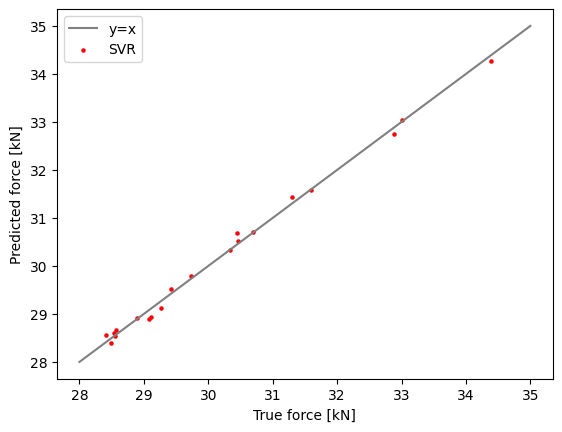

In [60]:
plt.plot([28, 35], [28, 35], label='y=x', color='gray')

plt.scatter(Y_val,Y_predicted_SVR, s=5, label= 'SVR', color='red')

plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.legend()